# An Analysis of Tweets About the Pfizer & BioNTech Vaccine

The data includes recent tweets about Pfizer & BioNTech vaccine. The data was downloaded from Kaggle (https://www.kaggle.com/gpreda/pfizer-vaccine-tweets), and it was collected using the tweepy Python package to access Twitter API. It will be analyzed using various NLP/sentiment analysis techniques as well as training classification algorithms to predict if a tweet will be retweeted.

In [269]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [6]:
tweets = pd.read_csv('vaccination_tweets.csv')
tweets.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [7]:
tweets.dtypes

id                   int64
user_name           object
user_location       object
user_description    object
user_created        object
user_followers       int64
user_friends         int64
user_favourites      int64
user_verified         bool
date                object
text                object
hashtags            object
source              object
retweets             int64
favorites            int64
is_retweet            bool
dtype: object

The date variable needs to change to a datetime format. Otherwise, every variable looks good.

In [8]:
tweets['date'] = pd.to_datetime(tweets['date'])

##### Adding variables representing Tweet Length and Hashtag Length 

In [9]:
tweets['tweet_character_count'] = tweets['text'].apply(len)
tweets['tweet_word_count'] = tweets['text'].str.split(' ').str.len()
tweets['hashtag_count'] = tweets['hashtags'].str.strip('][').str.split(', ').str.len()

## EDA

In [10]:
tweets.describe()

,id,user_followers,user_friends,user_favourites,retweets,favorites,tweet_character_count,tweet_word_count,hashtag_count
count,5.582000e+03,5.582000e+03,5582.000000,5582.000000,5582.000000,5582.000000,5582.000000,5582.000000,4175.000000
mean,1.347651e+18,3.752757e+04,1172.430312,13672.105518,1.668757,9.643855,130.595665,16.779828,2.504671
std,6.156723e+15,3.319605e+05,2605.334904,39854.739480,14.837014,67.148030,18.215627,4.526820,1.548889
min,1.337728e+18,0.000000e+00,0.000000,0.000000,0.000000,0.000000,30.000000,2.000000,1.000000
25%,1.341870e+18,1.090000e+02,165.000000,386.250000,0.000000,0.000000,130.000000,14.000000,1.000000
50%,1.347671e+18,4.790000e+02,465.000000,2068.500000,0.000000,1.000000,139.000000,17.000000,2.000000
75%,1.352224e+18,2.092750e+03,1245.750000,10444.250000,1.000000,4.000000,140.000000,20.000000,3.000000
max,1.361191e+18,1.371493e+07,99129.000000,924667.000000,678.000000,2315.000000,151.000000,71.000000,11.000000


In [11]:
tweets.is_retweet.value_counts(normalize=True)

False    1.0
Name: is_retweet, dtype: float64

All of the tweets in the "Is Retweet" Column are marked as "False". Obviously, this is incorrect and needs to be fixed

In [14]:
tweets.loc[tweets['retweets'] >= 1, 'is_retweet'] = 'True'
tweets.loc[tweets['retweets'] == 0, 'is_retweet'] = 'False'

tweets.is_retweet.value_counts(normalize=True)

False    0.695091
True     0.304909
Name: is_retweet, dtype: float64

30.5% of tweets were retweeted.

In [15]:
tweets.user_verified.value_counts(normalize=True)

False    0.902723
True     0.097277
Name: user_verified, dtype: float64

Only 10% of twitter users were user-verified.

In [16]:
tweets.source.value_counts(normalize=True)

Twitter for iPhone                 0.357104
Twitter Web App                    0.297796
Twitter for Android                0.229887
TweetDeck                          0.053037
Twitter for iPad                   0.029744
Buffer                             0.007346
Instagram                          0.006271
Hootsuite Inc.                     0.004300
IFTTT                              0.001613
Nonli                              0.001254
Blog2Social APP                    0.001075
Sendible                           0.001075
LinkedIn                           0.001075
SocialFlow                         0.000896
Microsoft Power Platform           0.000896
Twitter for Mac                    0.000717
24liveblog                         0.000717
Twitter Media Studio               0.000538
Echobox                            0.000358
Sprout Social                      0.000358
Falcon Social Media Management     0.000358
WordPress.com                      0.000358
Tweetbot for iΟS                

Most of the tweets come from either the iPhone app, Web app, or the Android app.

##### Missing Data

In [17]:
tweets.isnull().sum()

id                          0
user_name                   0
user_location            1164
user_description          353
user_created                0
user_followers              0
user_friends                0
user_favourites             0
user_verified               0
date                        0
text                        0
hashtags                 1407
source                      1
retweets                    0
favorites                   0
is_retweet                  0
tweet_character_count       0
tweet_word_count            0
hashtag_count            1407
dtype: int64

The only notable column with a lot of missing data is the "Hashtags" Variable. We can dichotomize this variable and see if there are patterns between tweets that present hashtags and tweets that do not present hashtags.

In [18]:
tweets.loc[tweets['hashtag_count']>=1,'has_hashtag'] = 'True'
tweets.loc[np.isnan(tweets['hashtag_count']),'has_hashtag'] = 'False'

In [19]:
tweets['has_hashtag'].value_counts(normalize=True)

True     0.74794
False    0.25206
Name: has_hashtag, dtype: float64

~75% of tweets had at least 1 hashtag associated with them.

##### Analyzing variables grouped by retweet status

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


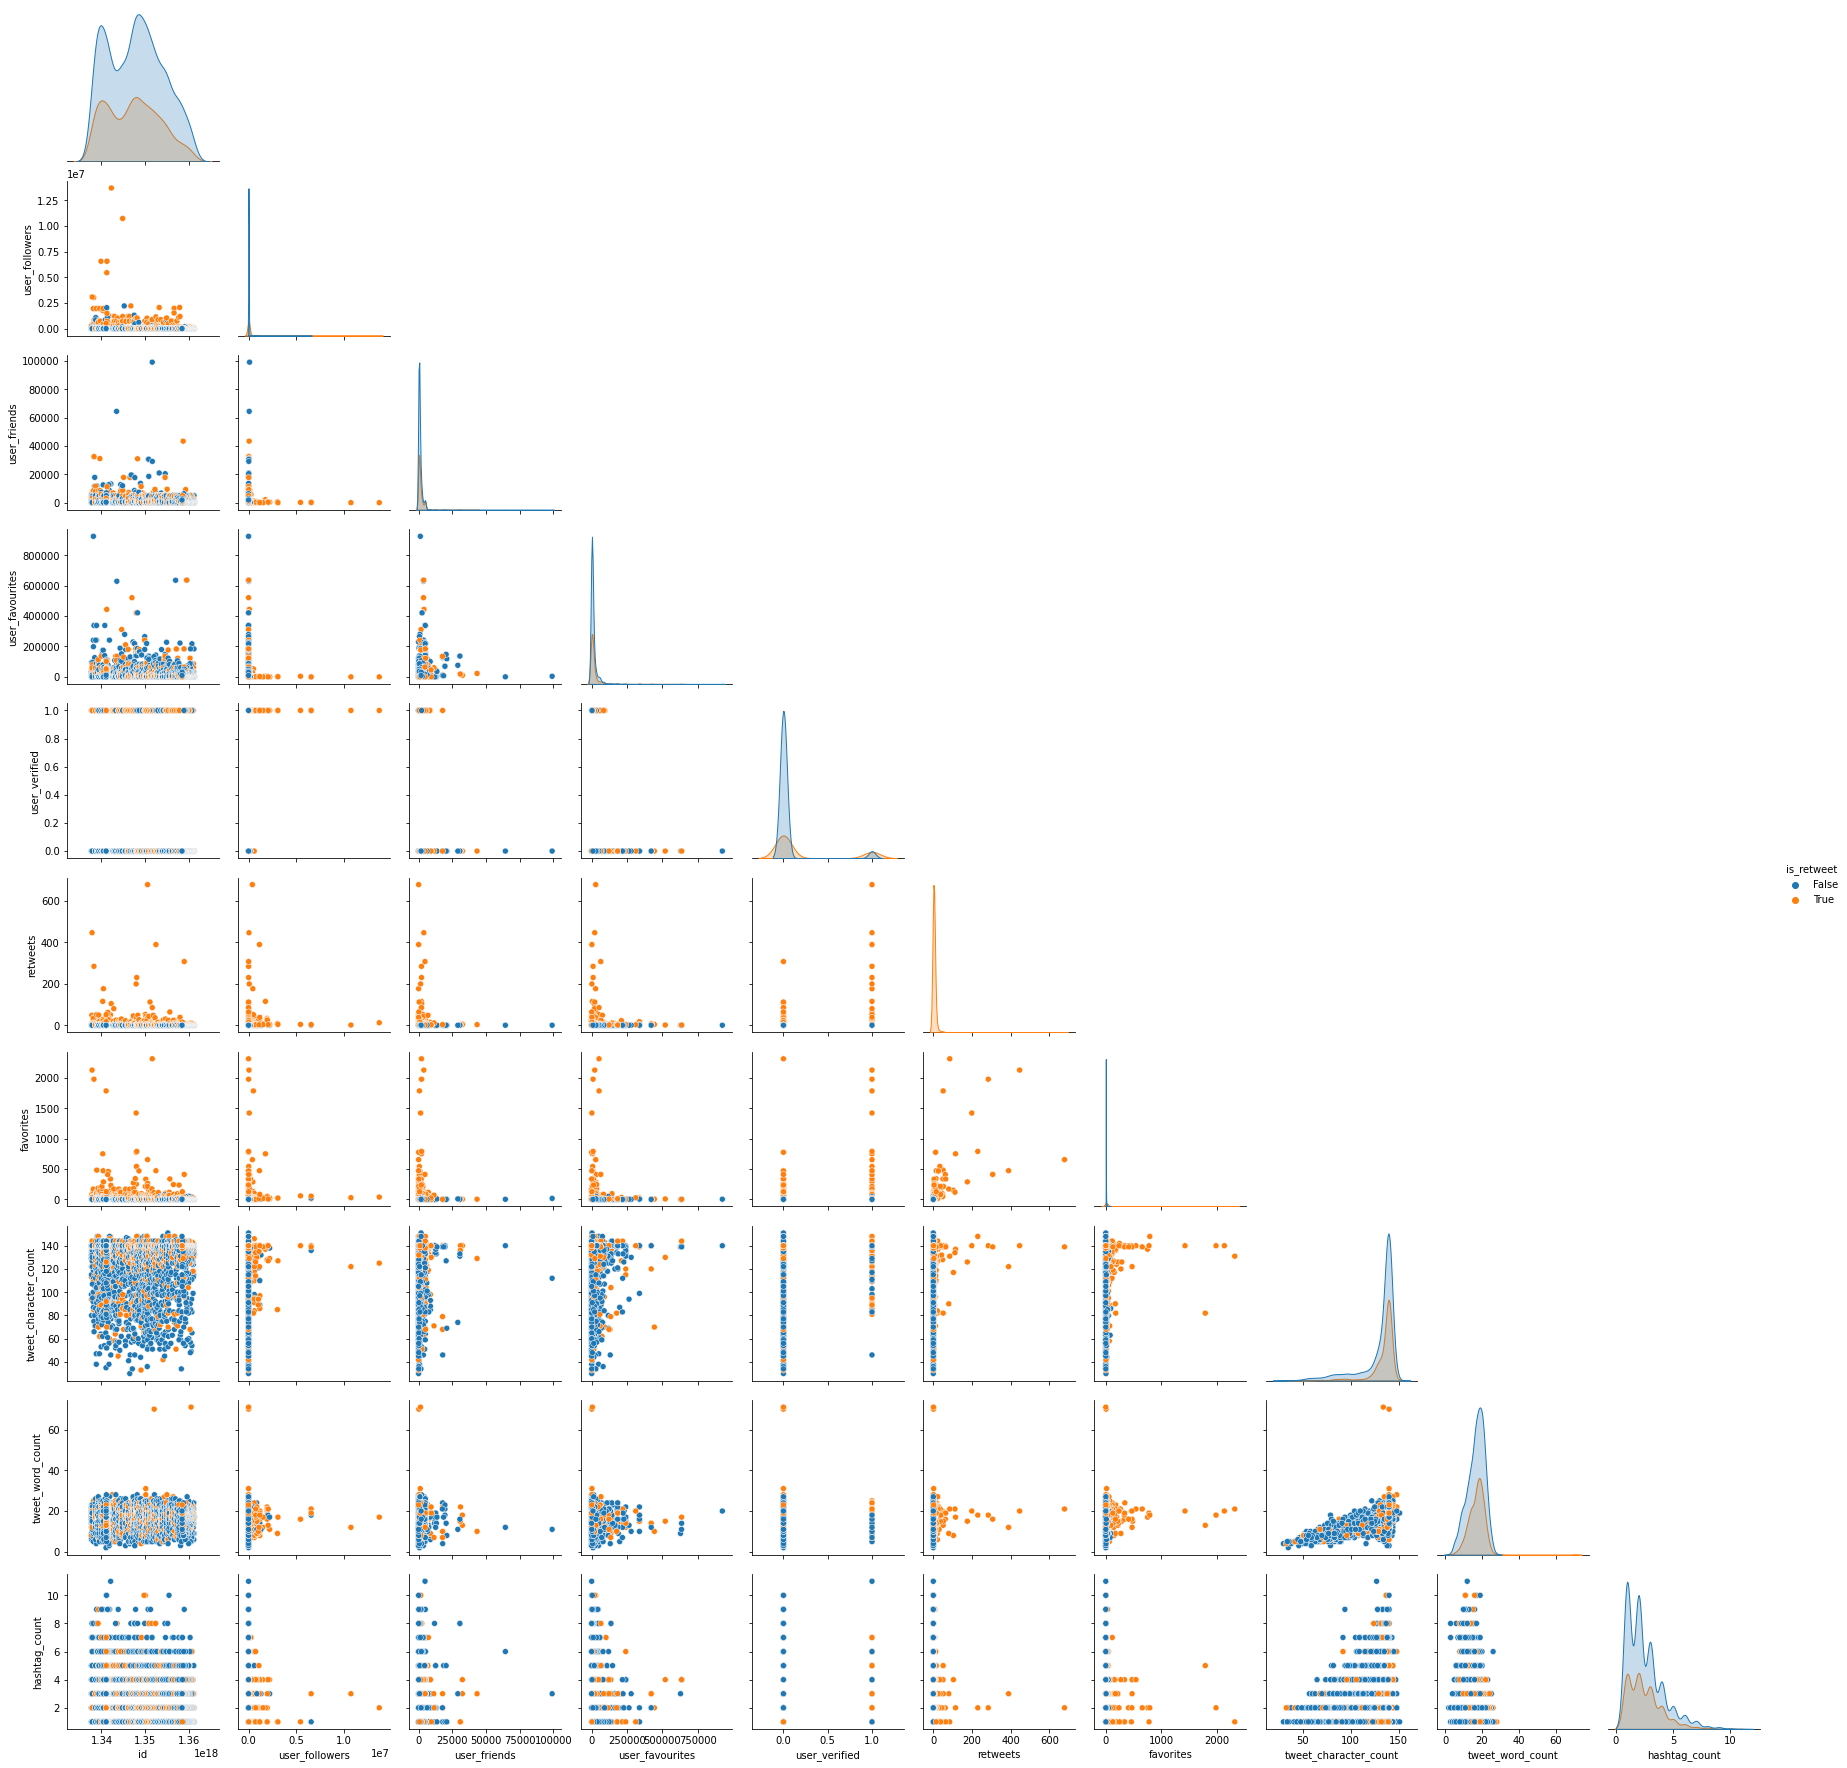

In [20]:
sns.pairplot(tweets, hue='is_retweet', corner=True)

In [21]:
tweets.groupby('is_retweet').mean()

,id,user_followers,user_friends,user_favourites,user_verified,retweets,favorites,tweet_character_count,tweet_word_count,hashtag_count
is_retweet,,,,,,,,,,
False,1.347802e+18,10776.851031,1047.364433,13055.281959,0.045103,0.000000,2.297680,129.248969,16.668557,2.499133
True,1.347308e+18,98510.396005,1457.539365,15078.260282,0.216216,5.472973,26.390717,133.665687,17.033490,2.517028


In [22]:
print(tweets.groupby('is_retweet')['has_hashtag'].value_counts(normalize=True))
print(tweets.groupby('is_retweet')['user_verified'].value_counts(normalize=True))

is_retweet  has_hashtag
False       True           0.743041
            False          0.256959
True        True           0.759107
            False          0.240893
Name: has_hashtag, dtype: float64
is_retweet  user_verified
False       False            0.954897
            True             0.045103
True        False            0.783784
            True             0.216216
Name: user_verified, dtype: float64


Based on the pairplot and mean comparisons, it appears that retweets are more common in users who are verified, have more followers, have more friends, and have more favorites. This implies that increased Twitter activity/engagement can have a significant impact in tweets being shared by others. Tweet length and hashtag count appear to not make a difference in retweet status.

##### Relationship between time of the day and retweets

In [23]:
tweets['Hour'] = tweets['date'].dt.hour

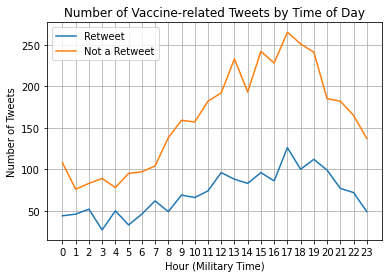

In [24]:
hours = tweets['Hour'].unique()

plt.plot(tweets.loc[tweets['is_retweet']=='True'].groupby('Hour').size(), label='Retweet')
plt.plot(tweets.loc[tweets['is_retweet']=='False'].groupby('Hour').size(), label= 'Not a Retweet')
plt.xticks(hours)
plt.xlabel('Hour (Military Time)')
plt.ylabel('Number of Tweets')
plt.title('Number of Vaccine-related Tweets by Time of Day')
plt.legend()
plt.grid()
plt.show()

Based on the line chart, there appears to be no distinction between the timing of tweets that were retweeted and not retweeted. However, the most active twitter activity is around 1:00pm and between 3-7pm. This makes sense since these times correspond to lunch breaks and times right after work.

## NLP Analysis

In [59]:
nltk.download('stopwords')
stemmer = SnowballStemmer(language='english')

def text_process(mess):

    #Remove Punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    #Rejoining Characters
    nopunc = ''.join(nopunc)
    
    #Stemming words to their root form
    for word in nopunc:
        stemmer.stem(word)
        
    #Removing Stopwords (i.e "a", "the", "but", etc), just common words with little value to the meaning of the sentence
    return [word.lower() for word in nopunc.split() if word.lower() not in stopwords.words('english')]

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1122)>


In [30]:
#Demonstrating Tweets with and Without Function
print(tweets['text'])
print(tweets['text'].apply(text_process))

0       Same folks said daikon paste could treat a cyt...
1       While the world has been on the wrong side of ...
2       #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3       Facts are immutable, Senator, even when you're...
4       Explain to me again why we need a vaccine @Bor...
                              ...                        
5577    Recent data published by the UK’s independent ...
5578    Feel extremely lucky to have had my first vacc...
5579    Thank you @DHA_Dubai for accommodating the vac...
5580    45 hours after second #PfizerBiontech #vaccina...
5581    Press &amp; govt go on about #AstraZeneca vacc...
Name: text, Length: 5582, dtype: object
0       [folks, said, daikon, paste, could, treat, cyt...
1       [world, wrong, side, history, year, hopefully,...
2       [coronavirus, SputnikV, AstraZeneca, PfizerBio...
3       [Facts, immutable, Senator, even, youre, ethic...
4       [Explain, need, vaccine, BorisJohnson, MattHan...
                              ..

In [60]:
tweets['text_processed'] = tweets['text'].apply(text_process)

##### Creating a List of Words Used in the Tweets

In [61]:
word_list = []

for line in tweets['text_processed']:
    for word in line:
        word_list.append(word)
        
word_list = pd.Series(word_list)
word_freq = word_list.value_counts()

##### Top 30 Words Used in Tweets Related to the Covid Vaccine

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


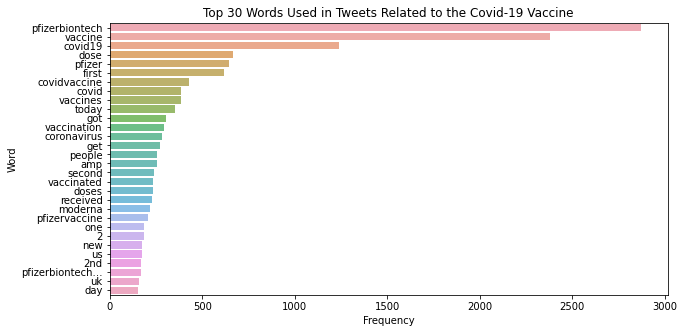

In [62]:
plt.figure(figsize=(10,5))
sns.barplot(word_freq[:30,].values, word_freq[:30,].index, alpha=0.8)
plt.title('Top 30 Words Used in Tweets Related to the Covid-19 Vaccine')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

While the words are pretty predictable, I noticed some of the most common words are "today", "got", "get", implying that a majority of the tweets are related to one getting the vaccine (more personal) rather than news about the vaccine itself. Additionally, tweets relating to the Pfizer-BioNTech Vaccine are obviously more prevalant than for the Moderna Vaccine.

##### Creating a List of Words used in Hashtags

In [63]:
hashtag_list = []
for line in tweets['hashtags'].dropna().str.strip('][').str.split(', '):
    for word in line:
        hashtag_list.append(word.lower())
        
hashtag_list = pd.Series(hashtag_list)

hashtag_freq = hashtag_list.value_counts()

##### Top 30 Words Used in Hashtags for Tweets Related to the Covid Vaccine

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


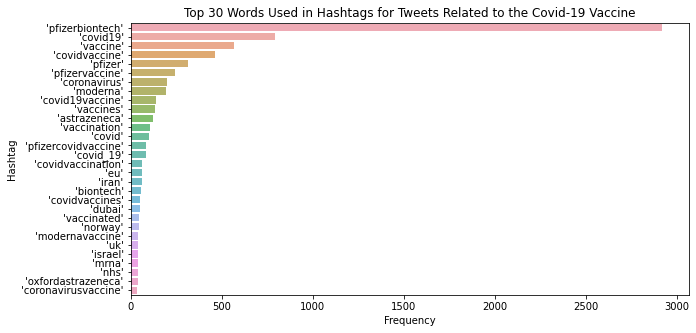

In [64]:
plt.figure(figsize=(10,5))
sns.barplot(hashtag_freq[:30,].values, hashtag_freq[:30,].index, alpha=0.8)
plt.title('Top 30 Words Used in Hashtags for Tweets Related to the Covid-19 Vaccine')
plt.xlabel('Frequency')
plt.ylabel('Hashtag')
plt.show()

I thought it was interesting how some frequent hashtags refer to locations, such as "Iran", "Dubai", "UK", and "Israel". Other than that, the most frequent hashtags were pretty predictable.

# Sentiment Analysis

In [65]:
tweets['text_processed_nolist'] = tweets['text_processed'].apply(lambda x: ' '.join(word for word in x))

In [67]:
tweets['polarity'] = tweets['text_processed_nolist'].apply(lambda x: TextBlob(x).sentiment[0])
tweets['subjectivity'] = tweets['text_processed_nolist'].apply(lambda x: TextBlob(x).sentiment[1])

##### Aggregate Statistics Based on Retweet Status

In [69]:
tweets.groupby('is_retweet')[['polarity', 'subjectivity']].agg([np.mean, np.median, np.min, np.max])

polarity                  subjectivity                    
                mean median amin amax         mean    median amin amax
is_retweet                                                            
False       0.100792    0.0 -1.0  1.0     0.276105  0.200000  0.0  1.0
True        0.113044    0.0 -1.0  1.0     0.273505  0.166667  0.0  1.0

Polarity doesn't seem to make a difference in retweet status. When stratified by status, tweets tend to skew towards a more positive sentiment. Subjectivity is virtually the same between tweets and no tweets. This is implying that the content of the tweet does not seem to predict the likelihood of retweet status. It all comes down to twitter engagement!

##### Visualizing Time Trend in Sentiment

In [74]:
sent_timetrend = tweets[['date', 'subjectivity', 'polarity']]
sent_timetrend = sent_timetrend.sort_values(by='date', ascending=True)

In [86]:
sent_dayavg = sent_timetrend.groupby(pd.Grouper(key='date', freq='D')).mean()

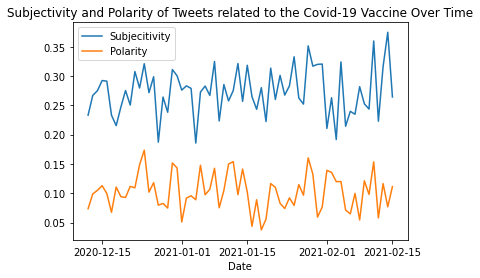

In [90]:
plt.plot(sent_dayavg.subjectivity, label='Subjecitivity')
plt.plot(sent_dayavg.polarity, label = 'Polarity')
plt.xlabel('Date')
plt.title('Subjectivity and Polarity of Tweets related to the Covid-19 Vaccine Over Time')
plt.legend()
plt.show()

While the graph does not seem to show any significant trend, the peaks for subjectivity appear to be increasing over time, possibly indicating that tweets are gradually becoming more subjective. This ties into the previous conclusion of a lot of the words having personal attachment to getting the vaccine rather than stating facts about the vaccine

The positive averages for polarity indicate that people in general have slightly positive sentiments about the vaccine.

## Classification

While the EDA was revealing, can we statistically show which factors are more likely to result in retweets? To do this, we will train classification models on our features to predict the likelihood of being retweeted. The following models will be created:

- Logistic Regression
- Decision Tree
- Random Forest
- Support Vector Machine

##### Extracting X's and Y and creating Training/Testing Sets

In [231]:
X = tweets[['user_followers', 'user_friends', 'user_favourites', 'user_verified', 'tweet_word_count', 'hashtag_count', 'has_hashtag', 'polarity', 'subjectivity']]

X.loc[X['has_hashtag']=='True', 'has_hashtag_num'] = 1
X.loc[X['has_hashtag']=='False', 'has_hashtag_num'] = 0

X = X.drop(['has_hashtag'], axis=1)

X = X.fillna(0)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [236]:
tweets.loc[tweets['is_retweet']=='True', 'is_retweet_num'] = 1
tweets.loc[tweets['is_retweet']=='False', 'is_retweet_num'] = 0

y = tweets.is_retweet_num

##### Checking Collinearity Issues

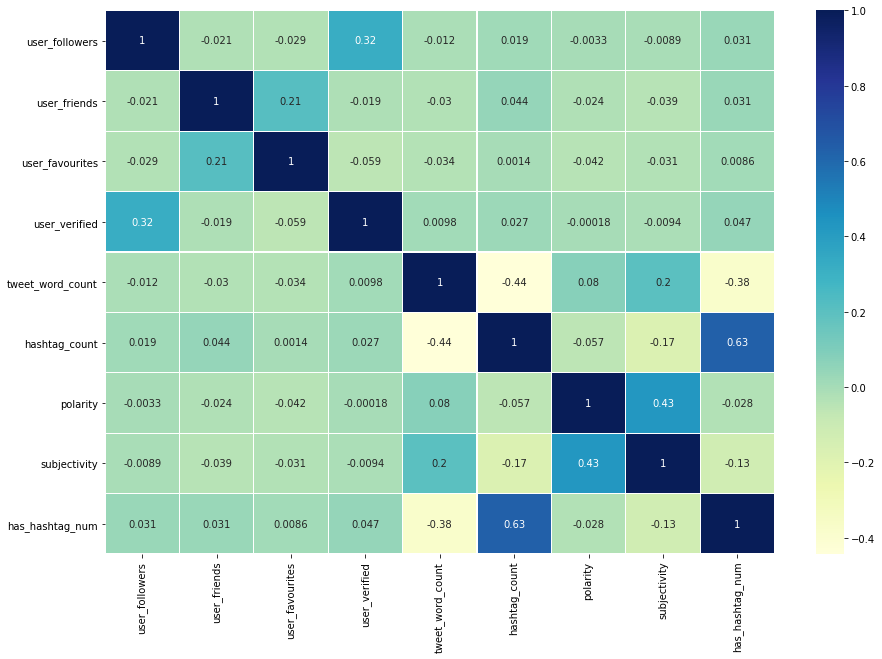

In [200]:
corr = X.corr()
matrix_cols = corr.columns.tolist()
corr_array = np.array(corr)
sns.heatmap(corr, annot=True, cmap='YlGnBu', linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(15,10)
plt.show()

The only serious multicollinearity issue is between "hashtag_count" and "has_hashtag_num". Previous analyses have indicated that hashtag count probably doesn't make a difference in retweet status, so we will remove this variable from the model building.

In [238]:
X = X.drop(['hashtag_count'], axis=1)

##### Creating Training/Testing Sets

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

##### Logistic Regression

In [245]:
logit = LogisticRegression()
logit.fit(X_train, y_train)
logit_pred = logit.predict(X_test)
print(classification_report(y_test,logit_pred))
print(confusion_matrix(y_test,logit_pred))

              precision    recall  f1-score   support

         0.0       0.69      0.99      0.81      1235
         1.0       0.74      0.08      0.15       608

    accuracy                           0.69      1843
   macro avg       0.71      0.53      0.48      1843
weighted avg       0.70      0.69      0.59      1843

[[1218   17]
 [ 559   49]]


##### Decision Tree

In [248]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)
print(classification_report(y_test,tree_pred))
print(confusion_matrix(y_test,tree_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.77      0.76      1235
         1.0       0.50      0.46      0.48       608

    accuracy                           0.67      1843
   macro avg       0.62      0.62      0.62      1843
weighted avg       0.66      0.67      0.67      1843

[[951 284]
 [327 281]]


##### Random Forest

In [249]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test,rfc_pred))
print(confusion_matrix(y_test,rfc_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.91      0.82      1235
         1.0       0.66      0.35      0.46       608

    accuracy                           0.73      1843
   macro avg       0.70      0.63      0.64      1843
weighted avg       0.71      0.73      0.70      1843

[[1125  110]
 [ 394  214]]


###### Support Vector Machine

In [251]:
svc = SVC()
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
print(classification_report(y_test,svc_pred))
print(confusion_matrix(y_test,svc_pred))

              precision    recall  f1-score   support

         0.0       0.69      0.97      0.81      1235
         1.0       0.68      0.13      0.22       608

    accuracy                           0.69      1843
   macro avg       0.69      0.55      0.52      1843
weighted avg       0.69      0.69      0.62      1843

[[1197   38]
 [ 527   81]]


Based on the classification reports anc confusion matrices, it appears that the Random Forest does the best job at classifying retweets/non-retweets (Accuracy = 0.73). Let's try and improve this model with a grid search.

##### Hyperparameter Tuning with GridSearchCV (5-Fold)

In [254]:
n_estimators = [int(x) for x in np.linspace(10,80,10)] #Number of Trees
max_features = ['auto', 'sqrt'] #Number of features at each split
max_depth = [2,4]# Maximum number of levels in tree
min_samples_split = [2, 5] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2] # Minimum number of samples required at each leaf node
bootstrap = [True, False] # Method of selecting samples for training each tree

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [255]:
rf_Grid = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                       cv = 5, verbose=2, n_jobs = 4)

In [256]:
rf_Grid.fit(X_train, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72,
                                          80]},
             verbose=2)

In [257]:
rf_Grid.best_params_

{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 25}

In [258]:
print (f'Train Accuracy - : {rf_Grid.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {rf_Grid.score(X_test,y_test):.3f}')

Train Accuracy - : 0.755
Test Accuracy - : 0.717


After tuning with our Grid Search,  our accuracy isn't improved that much (73% > 75%). We will fit one more series of models focusing on just variables that relate to twitter activity rather than tweet content

In [264]:
X2 = X[['user_followers', 'user_friends', 'user_favourites', 'user_verified']]
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.33, random_state=42)

In [267]:
#Logistic Regression
logit = LogisticRegression()
logit.fit(X_train, y_train)
logit_pred = logit.predict(X_test)
print('Classification Report: Logistic Regression')
print(classification_report(y_test,logit_pred))
print(confusion_matrix(y_test,logit_pred))

#Decision Tree
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)
print('Classification Report: Decision Tree')
print(classification_report(y_test,tree_pred))
print(confusion_matrix(y_test,tree_pred))

#Random Forest
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print('Classification Report: Random Forest')
print(classification_report(y_test,rfc_pred))
print(confusion_matrix(y_test,rfc_pred))

#Support Vector Machine
svc = SVC()
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
print('Classification Report: Support Vector Machine')
print(classification_report(y_test,svc_pred))
print(confusion_matrix(y_test,svc_pred))

Classification Report: Logistic Regression
              precision    recall  f1-score   support

         0.0       0.69      0.95      0.80      1235
         1.0       0.59      0.15      0.24       608

    accuracy                           0.69      1843
   macro avg       0.64      0.55      0.52      1843
weighted avg       0.66      0.69      0.62      1843

[[1173   62]
 [ 517   91]]
Classification Report: Decision Tree
              precision    recall  f1-score   support

         0.0       0.75      0.79      0.77      1235
         1.0       0.52      0.47      0.49       608

    accuracy                           0.68      1843
   macro avg       0.64      0.63      0.63      1843
weighted avg       0.68      0.68      0.68      1843

[[977 258]
 [324 284]]
Classification Report: Random Forest
              precision    recall  f1-score   support

         0.0       0.75      0.88      0.81      1235
         1.0       0.63      0.42      0.50       608

    accuracy   

When limiting our features, the accuracy scores virtually stay the same, indicating that tweet content does not have a significant impact on our modeling and cannot be considered significant predictors for retweet status.